In [1]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from scipy.stats import norm

In [2]:
# For reproducible results
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Task 1 - 1D diffusion process

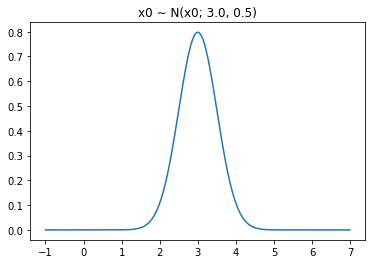

In [3]:
# x0 ∼ N(x0; m, p)
m = 3.0
p = 0.5

# Plot distribution of x0
x_axis = np.arange(-1, 7, 0.01)
plt.title(f"x0 ∼ N(x0; {m}, {p})")
plt.plot(x_axis, norm.pdf(x_axis, m, p))
plt.show()

In [4]:
# Iteratively runs forward diffusion on x0 for T timesteps
# returns: [x0, ... , xT]
def forward_diffuse(x0, T, Bt=0.25):
    xts = [x0]
    xt_prev = x0
    for i in range(T):
        ut = np.sqrt(1 - Bt) * xt_prev
        sigmat = np.sqrt(Bt)               # Bt*I = Bt*1 in the one dimensional case
        xt = np.random.normal(ut, sigmat)  # Using formula (1) from the project description; N.B. std instead of var since this is expected numpy arg
        xts.append(xt)
        xt_prev = xt
    return xts

In [5]:
# Uses closed formula to instantly compute xT from x0
# returns: xT
def forward_diffuse_closed(x0, T, Bt=0.25):
    at = 1 - Bt
    at_prod = np.power(at, T)
    uT = np.sqrt(at_prod) * x0
    sigmaT = np.sqrt(1 - at_prod)
    return np.random.normal(uT, sigmaT)

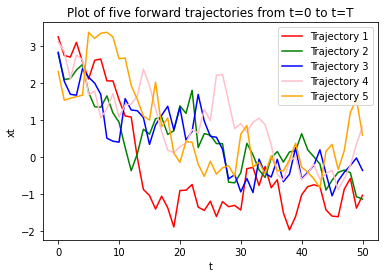

In [6]:
# Visualizing a few forward trajectories
T = 50
ts = range(0, T+1)
colors = ['red', 'green', 'blue', 'pink', 'orange']
for i in range(5):
    x0 = np.random.normal(m, p)
    xts = forward_diffuse(x0, T)
    plt.plot(ts, xts, color=colors[i], label=f"Trajectory {i+1}")
plt.legend()
plt.xlabel('t')
plt.ylabel('xt')
plt.title('Plot of five forward trajectories from t=0 to t=T')  
plt.show()

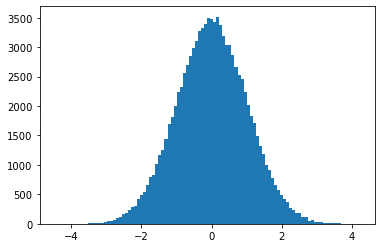

mean: 0.008170375464225088
std: 1.001863117753053


In [7]:
# Visualize the distrubution of xT, approximated from n trajectories
n = 100000    # more samples => better approximation => use closed formula for more efficient computation
xTs = []
for i in range(n):
    x0 = np.random.normal(m, p)
    xT = forward_diffuse_closed(x0, T)
    xTs.append(xT)

plt.hist(xTs, 100)
plt.show()

# Also compute mean and std of xT
print(f"mean: {np.mean(xTs)}\nstd: {np.std(xTs)}")

In [8]:
# Iteratively computes the reverse process, as a function of xt, x0, and t
# returns: [xt, ..., x0] where xi, i<t are the backward trajected values
def backward_diffuse(xt, t, x0, Bt=0.25):
    xts_reversed = [xt]
    at = 1 - Bt
    while(t > 0):
        at_prod = np.power(at, t)
        c1 = np.sqrt(at)*(1-at_prod/at) / (1-at_prod)
        c2 = np.sqrt(at_prod/at)*Bt / (1-at_prod)
        ut_tilde = c1*xt + c2*x0
        Bt_tilde = (1-at_prod/at) / (1-at_prod) * Bt
        xt_prev = np.random.normal(ut_tilde, np.sqrt(Bt_tilde))  # Compute q( x(t-1) | x(t), x(0) )
        xts_reversed.append(xt_prev)
        xt = xt_prev
        t = t-1
    return xts_reversed

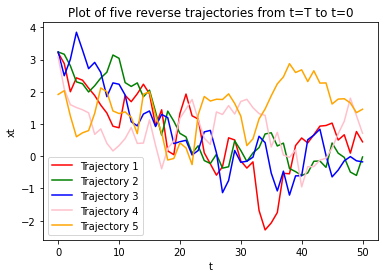

In [9]:
# Visualizing a few reverse trajectories
ts = range(0, T+1)
colors = ['red', 'green', 'blue', 'pink', 'orange']
for i in range(5):
    xT = np.random.normal(0, 1)
    x0 = np.random.normal(m, p)
    xts_reversed = backward_diffuse(xT, T, x0)
    xts = list(reversed(xts_reversed))    # just for plot, since ts is not reversed
    plt.plot(ts, xts, color=colors[i], label=f"Trajectory {i+1}")
plt.legend()
plt.xlabel('t')
plt.ylabel('xt')
plt.title('Plot of five reverse trajectories from t=T to t=0')  
plt.show()

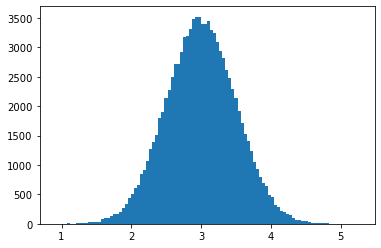

mean: 2.9981123694280862
std: 0.4987826034155103


In [10]:
# Visualize the distrubution of x0, approximated from n reverse trajectories
n = 100000    # more samples => better approximation => TODO: closed formula?
x0s = []
for i in range(n):
    xT = np.random.normal(0, 1)
    x0 = np.random.normal(m, p)
    x0_prim = backward_diffuse(xT, T, x0)[-1]   # should be equal to x0
    x0s.append(x0_prim)

plt.hist(x0s, 100)
plt.show()

# Also compute mean and std of x0
print(f"mean: {np.mean(x0s)}\nstd: {np.std(x0s)}")

## Task 2 - Learning a neural network to predict shapes from noise

In [4]:
# Returns the points in a txt file as a 2D ndarray
def read_points(file):
    with open(file, 'r') as f:
        lines = [line.rstrip('\n').split() for line in f]  # 2D array of shape [n, 2] with the point values as strings
        pts = np.zeros([len(lines), 2])
        for i, (x,y) in enumerate(lines):
            pts[i, 0] = float(x)
            pts[i, 1] = float(y)
        return pts

<function matplotlib.pyplot.show(close=None, block=None)>

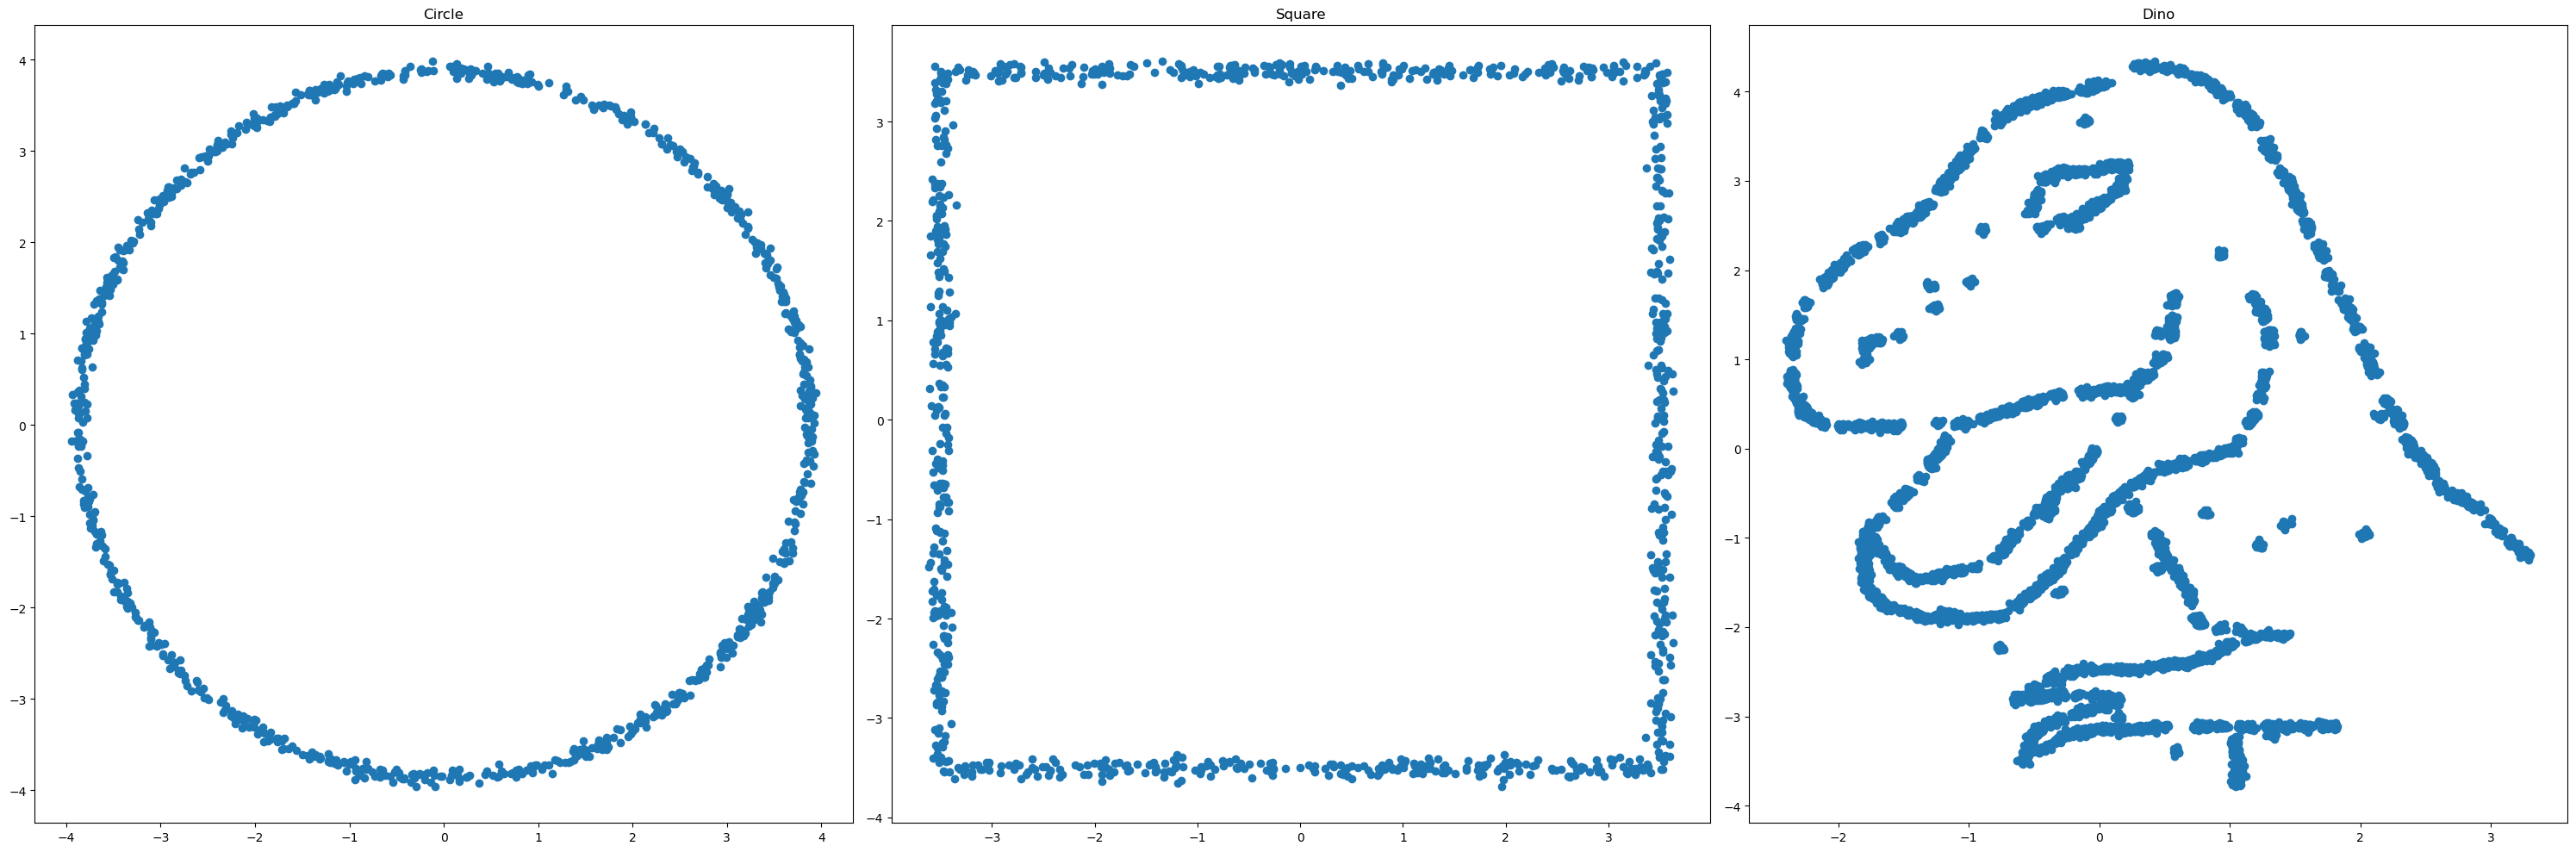

In [5]:
data_path = 'data'
circle_pts = read_points(os.path.join(data_path, 'circle_pts.txt'))
square_pts = read_points(os.path.join(data_path, 'square_pts.txt'))
dinohead_pts = read_points(os.path.join(data_path, 'dinohead_pts.txt'))

# Plot the original shapes
fig, axes = plt.subplots(1, 3, figsize=(30,10))
axes[0].scatter(circle_pts[:, 0], circle_pts[:, 1])
axes[0].set_title('Circle')
axes[1].scatter(square_pts[:, 0], square_pts[:, 1])
axes[1].set_title('Square')
axes[2].scatter(dinohead_pts[:, 0], dinohead_pts[:, 1])
axes[2].set_title('Dino')
plt.tight_layout()
plt.show()

In [13]:
# Learning constants
T = 200
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
# Layer embedding inputs using high-frequency sinusoidals
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.tensor([10000.0], device=device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device=device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

In [15]:
# Our Neural Network model
class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()

        self.emb_size = 32
        self.embedding = SinusoidalEmbedding(self.emb_size)
        self.linear1 = torch.nn.Linear(self.emb_size*3, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        self.linear3 = torch.nn.Linear(256, 64)
        self.linear4 = torch.nn.Linear(64, 2)
        self.activation = torch.nn.ReLU()

    def forward(self, xt, t):
        x = torch.cat((xt, t), dim=1)  # concatenate point xt and timestep t 
        x = self.embedding(x)          # embed input before processing
        x = torch.flatten(x, start_dim=1) # [batch_size, 3, emb_size] -> [batch_size, 3*emb_size]
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)     # no activation at output, since the noise e is continuous and possibly non-negaive
        return x  

In [16]:
# Linear variance schedule
# returns: tensor of shape [timesteps] containing all betas
def linear_beta_schedule(timesteps, start, end):
    return torch.linspace(start, end, timesteps, device=device)

# Compute all constants needed in forward and backward sampling
Bts = linear_beta_schedule(T, 0.0001, 0.02)
ats = 1.0 - Bts
ats_prods = torch.cumprod(ats, dim=0)
sqrt_ats_prods = torch.sqrt(ats_prods)
sqrt_ats_inv = torch.sqrt(1.0/ats)
sigmas = torch.sqrt(1.0 - ats_prods)
ats_prods_prev = F.pad(ats_prods[:-1], (1, 0), value=1.0) # shift ats_prods forward and let ats_prods_prev[0] = 1.0
Bt_tildes = (1.0-ats_prods_prev) / (1.0-ats_prods) * Bts
ut_tildes_et_factors = (1.0-ats)/(torch.sqrt(1.0-ats_prods)) 

In [17]:
# Uses closed formula to instantly compute xt from x0 and sampled noise e. Works with tensors of any length
# returns: xt
def forward_diffuse_closed_torch(x0, t, e):
    ut = torch.take(sqrt_ats_prods, t.long()-1) * x0
    sigmat = torch.take(sigmas, t.long()-1)
    return ut + sigmat*e

In [18]:
# Reverse samples n points from gaussian noise using provided model, and plots the scatter plot
def sample_and_scatter(model, T, n_points):
    
    xT = torch.randn((n_points, 2), device=device)  # Sample all xT from gaussian noise
    
    t = T
    xt = xT 
    
    # reverse sample until we get xt=x0
    while (t > 0):
        t_tensor = torch.full((n_points, 1), t, device=device).float()
        t_indexes = t_tensor.long()-1
        et = model(xt, t_tensor) # predict noise
        ut_tilde = torch.take(sqrt_ats_inv, t_indexes) * (xt - torch.take(ut_tildes_et_factors, t_indexes) * et)
        Bt_tilde = torch.take(Bt_tildes, t_indexes)
        xt_prev = torch.normal(ut_tilde, torch.sqrt(Bt_tilde))  # Compute p( x(t-1) | x(t), x(0) )
        t -= 1
        xt = xt_prev
        
    sampled_pts = xt.cpu().detach().numpy()  # our reverse sampled x0s as ndarrays
    plt.rcParams["figure.figsize"] = (7,7)
    plt.scatter(sampled_pts[:, 0], sampled_pts[:, 1])
    plt.show()

In [19]:
def fit_model(model, dataloader, optimizer, loss_fn, epochs):

    model.to(device)

    # Training loop
    for epoch in range(epochs):
    
        running_loss = 0.0
        n_batches = len(dataloader)
        for step, batch in enumerate(dataloader):
        
            # Transfers batch from cpu to device (needed when using gpu)
            batch = batch.float().to(device)   # also convert to float32 since this is torch default
        
            # Reset gradients
            optimizer.zero_grad()

            # Sample timesteps, noise, and apply forward diffusion
            t = torch.randint(1, T+1, (batch.shape[0], 1), device=device).float() # noise time step between 1-T 
            e = torch.randn_like(batch, device=device) # noise; tensor of same shape as batch, with values sampled from N(0,1)
            pts_diffused = forward_diffuse_closed_torch(batch, t, e)

            # Predict the noise from diffused points and timesteps
            e_pred = model(pts_diffused, t)
        
            # Compute loss and graidents
            loss = loss_fn(e_pred, e)
            loss.backward()

            # Update model weights
            optimizer.step()

            # Print loss at end of epoch
            running_loss += loss.item()
            if (step+1 == n_batches):
                print(f"epoch {epoch+1} loss: {running_loss/n_batches}")
                running_loss = 0.0

epoch 1 loss: 1.049998676404357
epoch 2 loss: 0.918672377243638
epoch 3 loss: 0.9721547681838274
epoch 4 loss: 0.9140729680657387
epoch 5 loss: 0.8287980314344168
epoch 6 loss: 0.8496190179139376
epoch 7 loss: 0.8220005817711353
epoch 8 loss: 0.7046580789610744
epoch 9 loss: 0.7040284425020218
epoch 10 loss: 0.6847494067624211
epoch 11 loss: 0.7130027720704675
epoch 12 loss: 0.7334904726594687
epoch 13 loss: 0.7063951976597309
epoch 14 loss: 0.6721619442105293
epoch 15 loss: 0.6357170483097434
epoch 16 loss: 0.6215857565402985
epoch 17 loss: 0.6531617632135749
epoch 18 loss: 0.6502115102484822
epoch 19 loss: 0.7037661941722035
epoch 20 loss: 0.6234537344425917
epoch 21 loss: 0.6461540050804615
epoch 22 loss: 0.6022278591990471
epoch 23 loss: 0.6007589371874928
epoch 24 loss: 0.6127617144957185
epoch 25 loss: 0.5725317914038897
epoch 26 loss: 0.5852698087692261
epoch 27 loss: 0.5970092928037047
epoch 28 loss: 0.5766050582751632
epoch 29 loss: 0.568041711114347
epoch 30 loss: 0.647653915

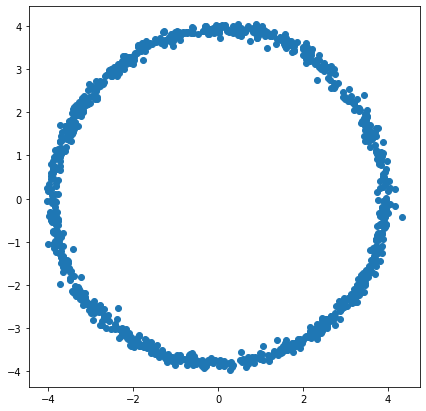

In [20]:
# Train and sample circle model
circle_model = MLP()
fit_model(
    model = circle_model, 
    dataloader = DataLoader(circle_pts, batch_size=32, shuffle=True), 
    optimizer = Adam(circle_model.parameters(), lr=1e-3),
    loss_fn = torch.nn.MSELoss(),
    epochs = 100
)    
sample_and_scatter(circle_model, T, 1000)

epoch 1 loss: 1.0140623021870852
epoch 2 loss: 0.9113610303029418
epoch 3 loss: 0.9064591582864523
epoch 4 loss: 0.875804603099823
epoch 5 loss: 0.8607579916715622
epoch 6 loss: 0.7600770285353065
epoch 7 loss: 0.7289165342226624
epoch 8 loss: 0.7262506280094385
epoch 9 loss: 0.7361678369343281
epoch 10 loss: 0.6884598359465599
epoch 11 loss: 0.7327415701001883
epoch 12 loss: 0.7336615147069097
epoch 13 loss: 0.6476196041330695
epoch 14 loss: 0.6778942020609975
epoch 15 loss: 0.660732239484787
epoch 16 loss: 0.6530410759150982
epoch 17 loss: 0.6575949368998408
epoch 18 loss: 0.6540947183966637
epoch 19 loss: 0.6145766898989677
epoch 20 loss: 0.6394423861056566
epoch 21 loss: 0.6151099372655153
epoch 22 loss: 0.6416819477453828
epoch 23 loss: 0.6352330148220062
epoch 24 loss: 0.615196168422699
epoch 25 loss: 0.6277163680642843
epoch 26 loss: 0.6051493687555194
epoch 27 loss: 0.6334756137803197
epoch 28 loss: 0.5991154862567782
epoch 29 loss: 0.5946159800514579
epoch 30 loss: 0.630499148

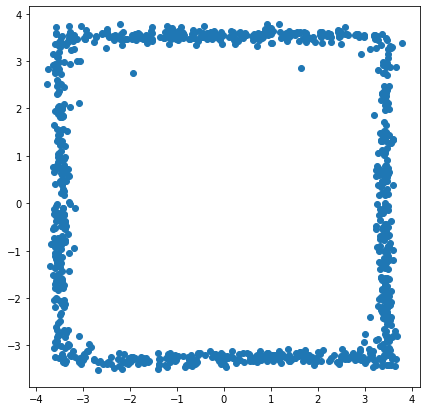

In [21]:
# Train and sample square model
square_model = MLP()
fit_model(
    model = square_model, 
    dataloader = DataLoader(square_pts, batch_size=32, shuffle=True), 
    optimizer = Adam(square_model.parameters(), lr=1e-3),
    loss_fn = torch.nn.MSELoss(),
    epochs = 100
)    
sample_and_scatter(square_model, T, 1000)

epoch 1 loss: 0.837716742604971
epoch 2 loss: 0.7110392645001411
epoch 3 loss: 0.707340294867754
epoch 4 loss: 0.6910881333053112
epoch 5 loss: 0.7014840364456176
epoch 6 loss: 0.6961826555430889
epoch 7 loss: 0.6975681945681572
epoch 8 loss: 0.688081119954586
epoch 9 loss: 0.6905218847095966
epoch 10 loss: 0.687194162607193
epoch 11 loss: 0.6944107070565224
epoch 12 loss: 0.6950292654335499
epoch 13 loss: 0.6901704482734203
epoch 14 loss: 0.6834256589412689
epoch 15 loss: 0.6769643031060696
epoch 16 loss: 0.6897136248648167
epoch 17 loss: 0.6893176406621933
epoch 18 loss: 0.6848293818533421
epoch 19 loss: 0.6745973125100135
epoch 20 loss: 0.6913909271359444
epoch 21 loss: 0.6839983075857162
epoch 22 loss: 0.6917139865458012
epoch 23 loss: 0.6771101154386997
epoch 24 loss: 0.6968785904347896
epoch 25 loss: 0.673644233494997
epoch 26 loss: 0.6598104685544968
epoch 27 loss: 0.6767650224268437
epoch 28 loss: 0.6681441619992257
epoch 29 loss: 0.688966891169548
epoch 30 loss: 0.674238066375

epoch 239 loss: 0.635005934908986
epoch 240 loss: 0.6488554112613201
epoch 241 loss: 0.6332989376038313
epoch 242 loss: 0.6408684276044369
epoch 243 loss: 0.6384050831198692
epoch 244 loss: 0.6530057802796364
epoch 245 loss: 0.6374090023338794
epoch 246 loss: 0.6353282440453768
epoch 247 loss: 0.6271203696727753
epoch 248 loss: 0.637220886349678
epoch 249 loss: 0.6474175199866294
epoch 250 loss: 0.6308355938643218
epoch 251 loss: 0.6485683109611273
epoch 252 loss: 0.637068934738636
epoch 253 loss: 0.6242242407053709
epoch 254 loss: 0.6360820412635804
epoch 255 loss: 0.636383942514658
epoch 256 loss: 0.6300963059067726
epoch 257 loss: 0.6422872833907605
epoch 258 loss: 0.6394379660487175
epoch 259 loss: 0.6362024560570717
epoch 260 loss: 0.6295617181807757
epoch 261 loss: 0.6455373868346215
epoch 262 loss: 0.6450616516172886
epoch 263 loss: 0.6397333770990372
epoch 264 loss: 0.635394835844636
epoch 265 loss: 0.6404047973453999
epoch 266 loss: 0.6457569777965546
epoch 267 loss: 0.6381196

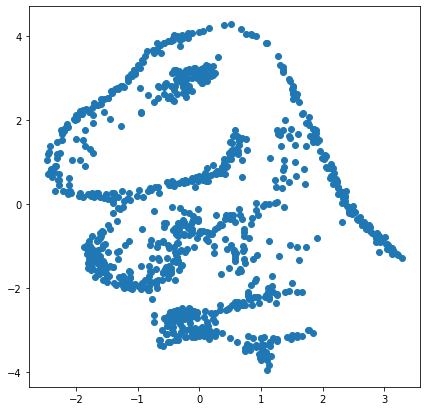

In [22]:
# Train and sample dinohead model
dino_model = MLP()
fit_model(
    model = dino_model, 
    dataloader = DataLoader(dinohead_pts, batch_size=128, shuffle=True), 
    optimizer = Adam(dino_model.parameters(), lr=1e-3),
    loss_fn = torch.nn.MSELoss(),
    epochs = 300
)    
sample_and_scatter(dino_model, T, 1000)

### Advanced part - Generating new data

Some samples of the stars data:


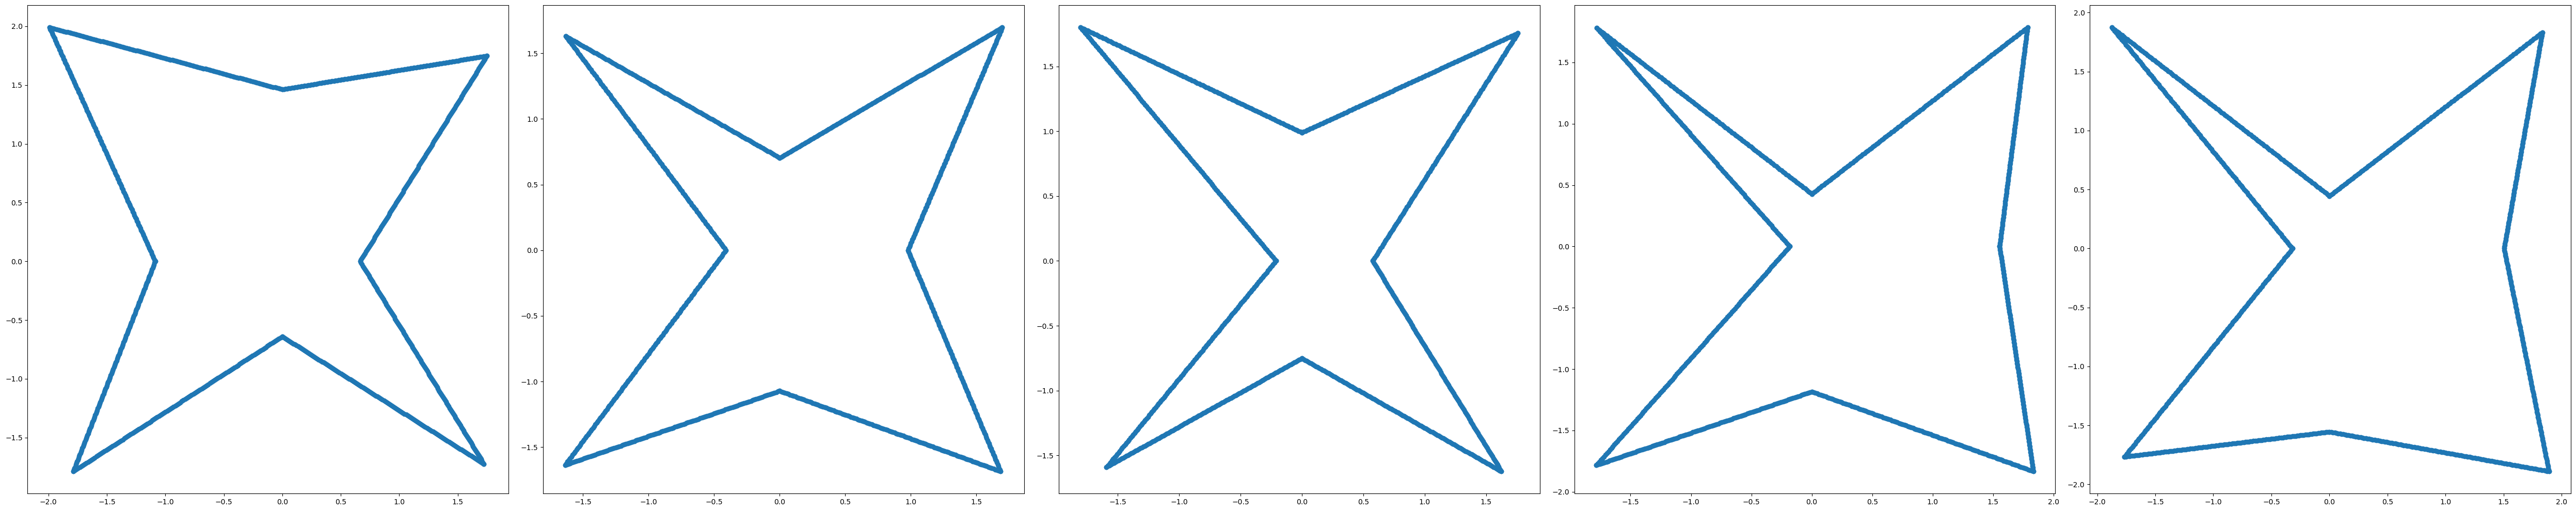

In [30]:
stars_data = np.load(os.path.join(data_path, 'stars_data.npy'))

# Plot some sample stars
fig, axes = plt.subplots(1, 5, figsize=(50,10))
for i in range(5):
    star = random.choice(stars_data)
    axes[i].scatter(star[:, 0], star[:, 1])

print('Some samples of the stars data:')
plt.tight_layout()
plt.show()

## Drafts (TODO: remove)

In [23]:
# Iteratively computes the reverse process, as a function of xt and t 
# (x0 is actually ignored since it can be represented as a function of xt, at_prod and et)*
# returns: [xt, ..., x0]
def backward_diffuse(xt, t, x0=None, Bt=0.25):
    xts_reversed = [xt]
    at = 1 - Bt
    while(t > 0):
        et = np.random.normal(0, 1)   # For representing x0 and simplifying formula for ut_tilde
        at_prod = np.power(at, t)
        ut_tilde = (1/at) * (xt - (1-at)/(np.sqrt(1-at_prod))*et)
        Bt_tilde = (1-at_prod/at) / (1-at_prod) * Bt
        xt_prev = np.random.normal(ut_tilde, np.sqrt(Bt_tilde))  # Compute q( x(t-1) | x(t), x(0) )
        xts_reversed.append(xt_prev)
        xt = xt_prev
        t = t-1
    return xts_reversed

# *TODO: reversed trajectored x0:s are huge! something not right in representation?